In [66]:
import json
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm

In [80]:
#takes path of TACO data and list of image IDs
def getTaco(p, imIds,cut_out=True):   
    ann_path = os.path.join(p, "annotations.json")
    coco = COCO(ann_path)
    
    litIms = []
    litMasks = []
    for imId in imIds: #for each image selected
        #get image object from coco annotations
        img = coco.imgs[imId]
        
        #get file name and join it to data path
        imp = os.path.join(p, img['file_name'])
        
        #get category ids
        cat_ids = coco.getCatIds()
        #get annotation ids
        anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        
        #load taco image
        im = cv2.cvtColor(cv2.imread(imp),cv2.COLOR_BGR2RGB)
        
        #for each annotation....
        
        for i, ann in enumerate(anns):
            mask = coco.annToMask(anns[i])

            #crop image and mask
            img_h,img_w,c = im.shape


            [x,y,w,h] = anns[i]['bbox']
            cropped_img = im[int(y):int(y+h), int(x):int(x+w),  :]
            cropped_mask = mask[int(y):int(y+h), int(x):int(x+w)]
        if cut_out:
            #Cutout rubbish using mask
            cut_img = cv2.bitwise_and(cropped_img,cropped_img,mask = cropped_mask)
        
            #add to array of samples
            litIms.append(cut_img)
        else:
            litIms.append(cropped_img)
        litMasks.append(cropped_mask)
        
    return litIms, litMasks

    
#https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)
    
    new_w = dim[0]
    new_h = dim[1]
    
    # return the resized image
    return resized, new_w, new_h


#get cropped litter samples from in house dashcam dataset.
#takes image and label path and count
def getDashLit(im_p,lab_p,cnt):
    batch = os.listdir(lab_p)[:cnt]

    litter_samps = []

    for ann_f in tqdm(batch):
        #get annotation path
        ann = os.path.join(gv_ann_labels,ann_f)

        #get image name from annotation file name
        im_name = ann_f.split('.')[:-1]
        im_name.append('jpg') #get image name from text name
        im_name = ".".join(im_name)

        #read image
        full_im_p = os.path.join(im_p,im_name)
        gv_im = cv2.cvtColor(cv2.imread(full_im_p),cv2.COLOR_BGR2RGB)

        imh = gv_im.shape[0]
        imw = gv_im.shape[1]

        #read annotation file (yolo)
        ann_txt = open(ann, 'r')
        lines = ann_txt.readlines() # read txt file
        ann_txt.close()

        #get annotation from each line
        for l in lines:
            no_nl = l.strip() # get rid of \n
            annotation = no_nl.split(' ')[1:] # split by space and remove 'class' (only one label)
            #unnormalise 
            xcen = float(annotation[0])*imw; ycen = float(annotation[1])*imh; w = float(annotation[2])*imw; h = float(annotation[3])*imh
            #convert centers to top left of bbox
            xmin = xcen-(w/2); ymin = ycen-(h/2) 
            cropped_img = gv_im[int(ymin):int(ymin+h), int(xmin):int(xmin+w),  :]
            litter_samps.append(cropped_img)
    return litter_samps


def getDashLitMetrics(im_p,lab_p):
    batch = os.listdir(lab_p)
    
    widths = []
    heights = []
    

    for ann_f in tqdm(batch):
        #get annotation path
        ann = os.path.join(gv_ann_labels,ann_f)

        #get image name from annotation file name
        im_name = ann_f.split('.')[:-1]
        im_name.append('jpg') #get image name from text name
        im_name = ".".join(im_name)

        #read image
        full_im_p = os.path.join(im_p,im_name)
        gv_im = cv2.cvtColor(cv2.imread(full_im_p),cv2.COLOR_BGR2RGB)

        imh = gv_im.shape[0]
        imw = gv_im.shape[1]

        #read annotation file (yolo)
        ann_txt = open(ann, 'r')
        lines = ann_txt.readlines() # read txt file
        ann_txt.close()

        #get annotation from each line
        for l in lines:
            no_nl = l.strip() # get rid of \n
            annotation = no_nl.split(' ')[1:] # split by space and remove 'class' (only one label)
            #unnormalise 
            w = float(annotation[2])*imw; h = float(annotation[3])*imh
            widths.append(w)
            heights.append(h)
            
    return widths,heights

In [16]:
taco_p = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\TACO\TACO-master\data"

In [18]:
ims,masks = getTaco(taco_p,[0,1,2,3,4,5],False)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


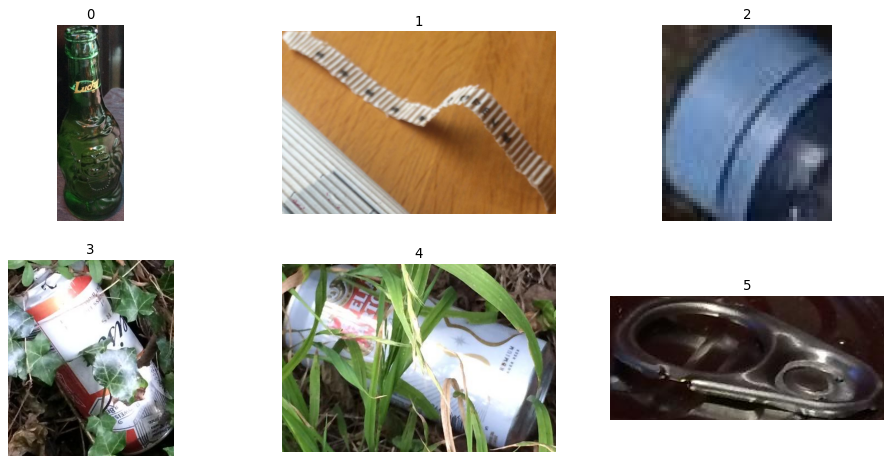

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7), dpi=80, sharex=False, sharey=False)
# ax[1].imshow(image1, cmap='gray')
# ax[0].imshow(image2, cmap='gray')

ax = ax.flatten()
for i in range(0,len(ims)):   
    ax[i].imshow(ims[i])
    ax[i].axis('off')
    ax[i].set_title(i)

In [59]:
#Print from our dataset
#note these annotations are in YOLO
gv_ann= r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\paper\ann_dataset\train"
gv_ann_ims = os.path.join(gv_ann,"images")
gv_ann_labels= os.path.join(gv_ann,"labels")

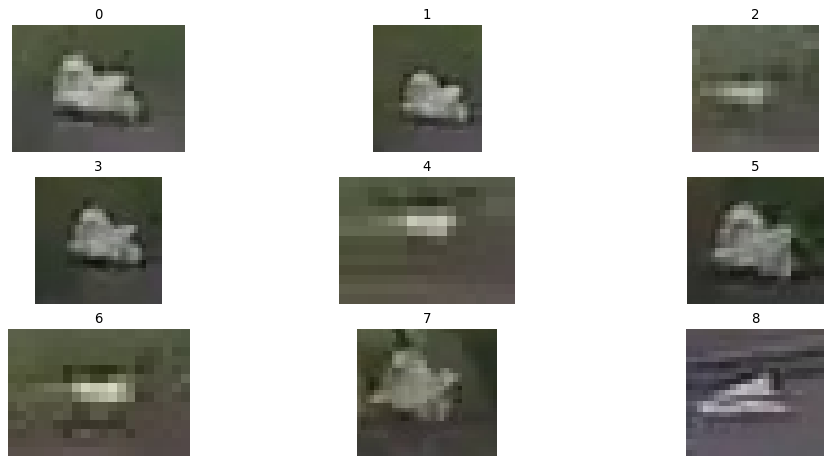

In [60]:
test_batch = os.listdir(gv_ann_labels)[:6]

litter_samps = []

for ann_f in test_batch:
    #get annotation path
    ann = os.path.join(gv_ann_labels,ann_f)
    
    #get image name from annotation file name
    im_name = ann_f.split('.')[:-1]
    im_name.append('jpg') #get image name from text name
    im_name = ".".join(im_name)
    
    #read image
    im_p = os.path.join(gv_ann_ims,im_name)
    gv_im = cv2.cvtColor(cv2.imread(im_p),cv2.COLOR_BGR2RGB)
    
    imh = gv_im.shape[0]
    imw = gv_im.shape[1]
    
    #read annotation file (yolo)
    ann_txt = open(ann, 'r')
    lines = ann_txt.readlines() # read txt file
    ann_txt.close()
    
    #get annotation from each line
    for l in lines:
        no_nl = l.strip() # get rid of \n
        annotation = no_nl.split(' ')[1:] # split by space and remove 'class' (only one label)
        #unnormalise 
        xcen = float(annotation[0])*imw; ycen = float(annotation[1])*imh; w = float(annotation[2])*imw; h = float(annotation[3])*imh
        #convert centers to top left of bbox
        xmin = xcen-(w/2); ymin = ycen-(h/2) 
        cropped_img = gv_im[int(ymin):int(ymin+h), int(xmin):int(xmin+w),  :]
        litter_samps.append(cropped_img)
        

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 7), dpi=80, sharex=False, sharey=False)

ax = ax.flatten()
for i in range(0,len(litter_samps)):   
    ax[i].imshow(litter_samps[i])
    ax[i].axis('off')
    ax[i].set_title(i)
    

In [73]:
#test dashlit function
dashlit = getDashLit(gv_ann_ims, gv_ann_labels,100)
#Insufficient memory :(

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.01it/s]


C:\Users\Computing\AppData\Local\Temp\ipykernel_6908\2094247278.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selection = np.random.choice(dashlit,9)


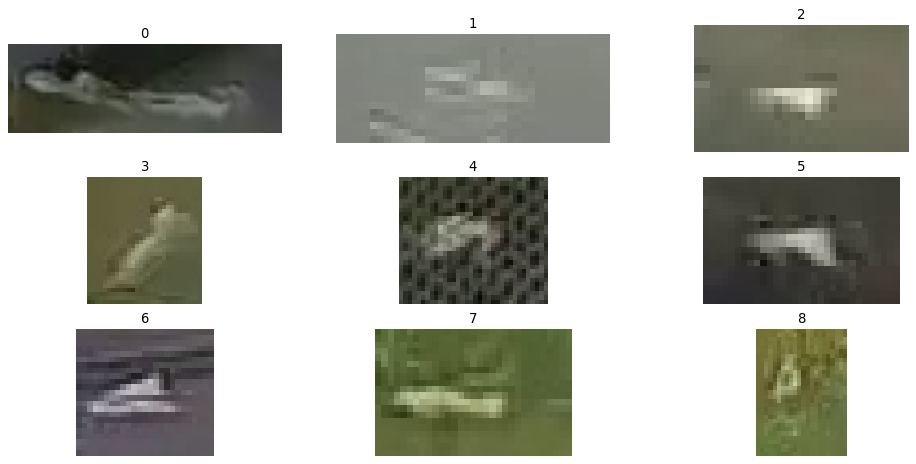

In [76]:
selection = np.random.choice(dashlit,9)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 7), dpi=80, sharex=False, sharey=False)

ax = ax.flatten()
for i in range(0,len(selection)):   
    ax[i].imshow(selection[i])
    ax[i].axis('off')
    ax[i].set_title(i)

In [81]:
#get some metrics
dashlitW, dashlitH = getDashLitMetrics(gv_ann_ims, gv_ann_labels)

100%|██████████████████████████████████████████████████████████████████████████████| 7990/7990 [04:32<00:00, 29.33it/s]


In [89]:
#area of dashlit dataset
dashlitA = [w*h for w,h in zip(dashlitW,dashlitH)]
#get per point in future?

In [94]:
dashlitA[0]

850.0

Mean Dashlit litter area: 745.3353591914778
Std Dev Dashlit litter area:: 1218.8930862797579


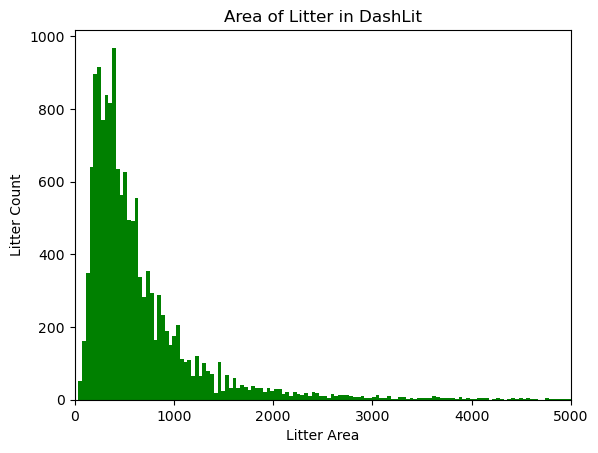

In [104]:
plt.hist(dashlitA, bins=1000,color='g')
plt.title("Area of Litter in DashLit")
plt.xlabel("Litter Area")
plt.ylabel("Litter Count")
plt.xlim([0, 5000])
print("Mean Dashlit litter area:",np.mean(dashlitA))
print("Std Dev Dashlit litter area::",np.std(dashlitA))

In [ ]:
#Now resize taco and show difference, save dashlit pieces, style transfer?